---
# **Title**

---

Student Name: Aviel Avshalumov



# Preliminaries

## Libraries

In [47]:
#Install Plotly if not already installed
!pip install plotly
!pip install pykalman
!pip install pymc3
!pip install statsmodels
!pip install scipy
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.2 MB/s eta 0:00:00


In [2]:
# Import required libraries
from google.colab import drive
import os
import pandas as pd

# Import Plotly libraries
import plotly.express as px    # For simple visualizations
import plotly.graph_objects as go  # For more complex visualizations
import plotly.io as pio        # For setting display configurations
import matplotlib.pyplot as plt

## Input Data

In [56]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the notebook's directory on Google Drive
notebook_directory = "/content/drive/MyDrive/Synthetic Control Methods/data"

# Construct the path to the CSV file
csv_file_path = os.path.join(notebook_directory, 'Financial Data.csv')

# Load the CSV file into a DataFrame
financial_data = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
financial_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Date       USCPI  Euro Stoxx  FedFunds      SPX  30YRTreasury  \
0  2000-01-31  168.800000     4684.48      5.87  1394.46         6.491   
1  2000-02-01  168.805793     4792.04      5.79  1409.28         6.423   
2  2000-02-02  168.814411     4902.12      5.64  1409.12         6.284   
3  2000-02-03  168.825766     5046.12      5.71  1424.97         6.136   
4  2000-02-04  168.839774     5119.79      5.70  1424.37         6.271   

   FTSE Index  10YRTreasury  Unemployment Rate  MoodysBaa  2YR Treasury  \
0      6268.5         6.665           4.000000       8.36         6.591   
1      6290.9         6.619           4.005623       8.27         6.574   
2      6302.8         6.573           4.011121       8.22         6.592   
3      6324.3         6.489           4.016491       8.13         6.523   
4      6185.0         6.549           4.021730       8.13         6.618   

     Nikkei  MSCI Emerging Markets  
0  19539.70                 491.39  
1  19423.38                 495.36  
2  19578.91                 499.46  
3  19786.42                 509.63  
4  19763.13                 515.43

# Data Management

In [64]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import kaleido
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from scipy.interpolate import CubicSpline
from pykalman import KalmanFilter
import os

# Preliminaries: Import libraries and define constants
def load_and_preprocess_data(csv_file_path):
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Apply cubic spline interpolation, stationarity check, and normalization for all columns
    for column in data.columns:
        if pd.infer_freq(data.index) != 'D':
            daily_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
            cs = CubicSpline(data.index.astype('int64') // 10**9, data[column].astype(float))
            interpolated = cs(daily_index.astype('int64') / 10**9)
            data[column] = pd.Series(interpolated, index=daily_index)

        # Stationarity test
        result = adfuller(data[column].dropna())
        if result[1] > 0.05:
            data[column] = data[column].diff().dropna()

        # Normalize data
        data[column] = (data[column] - data[column].mean()) / data[column].std()

    return data

# Analytics: Dynamic Bayesian Synthetic Control (DBSC)
def fit_dbsc_model(y_treated, y_control):
    n = len(y_control.columns)
    weights = np.random.dirichlet(np.ones(n), size=1).flatten()
    if y_control.empty:
        raise ValueError('Control data is empty. Check input columns.')
    synthetic_control = np.dot(y_control.values, weights) + y_control.mean(axis=1).values

    # Kalman filter for time-varying parameters
    kf = KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]],
                      initial_state_mean=[0], initial_state_covariance=[[1]],
                      observation_covariance=[[1]], transition_covariance=[[0.1]])
    filtered_state_means, _ = kf.filter(y_treated.values)

    return synthetic_control, filtered_state_means

# Visualization: Plot treatment effects
def plot_treatment_effect(y_treated, y_synthetic):
    treatment_effect = y_treated - y_synthetic
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_treated.index, y=y_treated, mode='lines', name='Treated'))
    fig.add_trace(go.Scatter(x=y_treated.index, y=y_synthetic, mode='lines', name='Synthetic Control'))
    fig.add_trace(go.Scatter(x=y_treated.index, y=treatment_effect, mode='lines', name='Treatment Effect'))
    fig.update_layout(title='Dynamic Bayesian Synthetic Control (DBSC) Results', font=dict(size=12))
    # Remove the write_image line if kaleido issues persist
# fig.write_image("dbsc_results.png", scale=3)
    fig.show()

# File path already defined, so we call the function directly
data = load_and_preprocess_data(csv_file_path)
print('Columns in DataFrame:', data.columns)
y_treated = data['SPX'].values.reshape(-1, 1)
y_control = data.drop(columns=['SPX'], errors='ignore').copy()
print('Control columns:', y_control.columns)
y_synthetic, filtered_states = fit_dbsc_model(pd.Series(y_treated.flatten(), index=data.index), y_control)
plot_treatment_effect(pd.Series(y_treated.flatten(), index=data.index), y_synthetic)


Columns in DataFrame: Index(['USCPI', 'Euro Stoxx', 'FedFunds', 'SPX', '30YRTreasury', 'FTSE Index',
       '10YRTreasury', 'Unemployment Rate', 'MoodysBaa', '2YR Treasury',
       'Nikkei', 'MSCI Emerging Markets'],
      dtype='object')
Control columns: Index(['USCPI', 'Euro Stoxx', 'FedFunds', '30YRTreasury', 'FTSE Index',
       '10YRTreasury', 'Unemployment Rate', 'MoodysBaa', '2YR Treasury',
       'Nikkei', 'MSCI Emerging Markets'],
      dtype='object')


In [76]:
from sklearn.metrics import mean_squared_error

# Robustness Check: RMSE, DIC, WAIC
def robustness_check(y_treated, y_synthetic):
    # Calculate RMSE
    rmse = mean_squared_error(np.nan_to_num(y_treated), np.nan_to_num(y_synthetic))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Calculate Mean Absolute Error
    mae = np.mean(np.abs(y_treated - y_synthetic))
    print(f"Mean Absolute Error (MAE): {mae}")

    # Calculate WAIC approximation (simplified)
    residuals = y_treated - y_synthetic
    waic = -2 * np.mean(np.log(np.exp(-0.5 * residuals**2).mean()))
    print(f"WAIC (approx): {waic}")

    return rmse, mae, waic


# Sensitivity to Macroeconomic Indicators
def analyze_macro_sensitivity(data, indicators):
    fig = go.Figure()
    for indicator in indicators:
        if indicator in data.columns:
            fig.add_trace(go.Scatter(x=data.index, y=data[indicator], mode='lines', name=indicator))
    fig.update_layout(title='Macroeconomic Indicator Trends', font=dict(size=12))
    fig.show()


# Model Comparison: Traditional SCM vs. DBSC
def compare_models(y_treated, y_control):
    # Traditional SCM
    weights = np.linalg.lstsq(np.nan_to_num(y_control), np.nan_to_num(y_treated), rcond=None)[0]
    traditional_synthetic = y_control @ weights

    # Dynamic Bayesian SCM (already calculated)
    dbsc_synthetic = y_synthetic

    # Plot comparison
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=y_treated.flatten(), mode='lines', name='Treated'))
    fig.add_trace(go.Scatter(x=data.index, y=traditional_synthetic.values.flatten(), mode='lines', name='Traditional SCM'))
    fig.add_trace(go.Scatter(x=data.index, y=dbsc_synthetic, mode='lines', name='DBSC'))
    fig.update_layout(title='Model Comparison: Traditional SCM vs. DBSC', font=dict(size=12))
    fig.show()


# Run enhancements
print("Running robustness check...")
rmse, mae, waic = robustness_check(y_treated[1:].flatten(), y_synthetic[1:].flatten())

print("Analyzing macroeconomic sensitivity...")
macro_indicators = ['USCPI', 'FEDFUNDS', 'GDP']
analyze_macro_sensitivity(data, macro_indicators)

print("Comparing DBSC with Traditional SCM...")
compare_models(y_treated, y_control)


Running robustness check...
Root Mean Squared Error (RMSE): 1.30534569882412
Mean Absolute Error (MAE): 0.8151267686129642
WAIC (approx): 0.6560326541552863
Analyzing macroeconomic sensitivity...


Comparing DBSC with Traditional SCM...


In [69]:
y_synthetic

array([        nan, -0.36271111, -0.52304527, ..., -0.46440361,
        0.64348565,  0.28008055])

# Analytics

# Simulation Resuts

In [173]:
import numpy as np
import pandas as pd

# Simulation Analysis for DBSC Framework
def simulate_data(n_units=20, t_periods=1000, t_treatment=70):
    # Generate synthetic data
    np.random.seed(42)
    time = np.arange(t_periods)
    data = pd.DataFrame(index=time)

    # Generate baseline and control units
    for i in range(n_units):
        baseline = np.sin(time / 10) + np.random.normal(0, 0.5, t_periods)
        treatment_effect = np.zeros(t_periods)

        # Introduce treatment effect for the treated unit after t_treatment
        if i == 0:
            treatment_effect[t_treatment:] = 3 + 0.5 * np.sin(time[t_treatment:] / 5)

        data[f'Unit_{i+1}'] = baseline + treatment_effect

    # Add macroeconomic indicators
    data['USCPI'] = np.random.normal(0, 1, t_periods)
    data['FEDFUNDS'] = np.cumsum(np.random.normal(0, 0.1, t_periods))
    data['GDP'] = 2 + 0.1 * time + np.random.normal(0, 0.5, t_periods)

    return data

# Evaluate model performance on simulated data
def evaluate_simulation(y_treated, y_synthetic):
    residuals = y_treated - y_synthetic
    rmse = np.sqrt(np.mean(residuals**2))
    print(f"Simulation RMSE: {rmse}")
    return rmse

# Run the simulation
print("Running simulation analysis...")
simulated_data = simulate_data()

# Simulate the treated and synthetic control series
y_treated_sim = simulated_data['Unit_1'].values
y_control_sim = simulated_data.drop(columns=['Unit_1']).values
weights = np.linalg.lstsq(y_control_sim, y_treated_sim, rcond=None)[0]
y_synthetic_sim = y_control_sim @ weights

# Evaluate the simulated model
evaluate_simulation(y_treated_sim, y_synthetic_sim)

# Plot the simulated series
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=simulated_data.index, y=y_treated_sim, mode='lines', name='Treated (Simulated)'))
fig.add_trace(go.Scatter(x=simulated_data.index, y=y_synthetic_sim, mode='lines', name='Synthetic Control (Simulated)'))
fig.update_layout(title='Simulation Analysis: Treated vs Synthetic', font=dict(size=12))
fig.show()


Running simulation analysis...
Simulation RMSE: 1.353031340726693


In [174]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

# Extend DBSC with Multivariate Outcomes and Dynamic Shrinkage Priors
def fit_multivariate_dbsc(y_treated, y_controls):
    n, t = y_controls.shape
    weights = np.random.dirichlet(np.ones(t), size=1).flatten()
    synthetic_control = np.dot(y_controls, weights)

    # Initialize parameters
    alpha = np.zeros(t)
    beta = np.zeros((n, t))
    sigma_alpha = np.abs(np.random.normal(0, 1))  # Ensure positive scale
    sigma_beta = np.abs(np.random.normal(0, 1, size=n))  # Ensure positive scale

    # Time-varying estimation
    for i in range(1, t):
        alpha[i] = alpha[i-1] + np.random.normal(0, sigma_alpha)
        for j in range(n):
            beta[j, i] = beta[j, i-1] + np.random.normal(0, sigma_beta[j])

    # Compute the synthetic control
    y_synthetic = alpha + beta * y_controls


    return y_synthetic

# Robustness Check: RMSE, DIC, WAIC
def robustness_check(y_treated, y_synthetic):
    # Calculate RMSE
    rmse = mean_squared_error(np.nan_to_num(y_treated), np.nan_to_num(y_synthetic))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Calculate Mean Absolute Error
    mae = np.mean(np.abs(y_treated - y_synthetic))
    print(f"Mean Absolute Error (MAE): {mae}")

    # Calculate WAIC approximation (simplified)
    residuals = y_treated - y_synthetic
    waic = -2 * np.mean(np.log(np.exp(-0.5 * residuals**2).mean()))
    print(f"WAIC (approx): {waic}")

    return rmse, mae, waic

# Sensitivity to Macroeconomic Indicators
def analyze_macro_sensitivity(data, indicators):
    fig = go.Figure()
    for indicator in indicators:
        if indicator in data.columns:
            fig.add_trace(go.Scatter(x=data.index, y=data[indicator], mode='lines', name=indicator))
    fig.update_layout(title='Macroeconomic Indicator Trends', font=dict(size=12))
    fig.show()

# Model Comparison: Traditional SCM vs. DBSC
def compare_models(y_treated, y_control):
    # Traditional SCM
    weights = np.linalg.lstsq(np.nan_to_num(y_control), np.nan_to_num(y_treated), rcond=None)[0]
    traditional_synthetic = y_control @ weights

    # Dynamic Bayesian SCM (already calculated)
    dbsc_synthetic = y_synthetic

    # Plot comparison
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=y_treated.flatten(), mode='lines', name='Treated'))
    fig.add_trace(go.Scatter(x=data.index, y=traditional_synthetic.values.flatten(), mode='lines', name='Traditional SCM'))
    fig.add_trace(go.Scatter(x=data.index, y=dbsc_synthetic, mode='lines', name='DBSC'))
    fig.update_layout(title='Model Comparison: Traditional SCM vs. DBSC', font=dict(size=12))
    fig.show()

# Run enhancements
print("Running robustness check...")
rmse, mae, waic = robustness_check(y_treated[1:].flatten(), y_synthetic[1:].flatten())

print("Analyzing macroeconomic sensitivity...")
macro_indicators = ['USCPI', 'FEDFUNDS', 'GDP']
analyze_macro_sensitivity(data, macro_indicators)

print("Comparing DBSC with Traditional SCM...")
compare_models(y_treated, y_control)

print("Running Multivariate DBSC with Dynamic Shrinkage Priors...")
y_synthetic_multivariate = fit_multivariate_dbsc(y_treated.flatten(), y_control.to_numpy())

# Plot multivariate results
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=y_treated.flatten(), mode='lines', name='Treated'))
fig.add_trace(go.Scatter(x=data.index, y=y_synthetic_multivariate.flatten(), mode='lines', name='Multivariate DBSC'))
fig.update_layout(title='Multivariate DBSC with Dynamic Shrinkage Priors', font=dict(size=12))
fig.show()

Running robustness check...
Root Mean Squared Error (RMSE): 1.30534569882412
Mean Absolute Error (MAE): 0.8151267686129642
WAIC (approx): 0.6560326541552863
Analyzing macroeconomic sensitivity...


Comparing DBSC with Traditional SCM...


Running Multivariate DBSC with Dynamic Shrinkage Priors...


In [102]:
y_control.shape

(5544, 11)

Running Gibbs Sampling for Bayesian Inference...


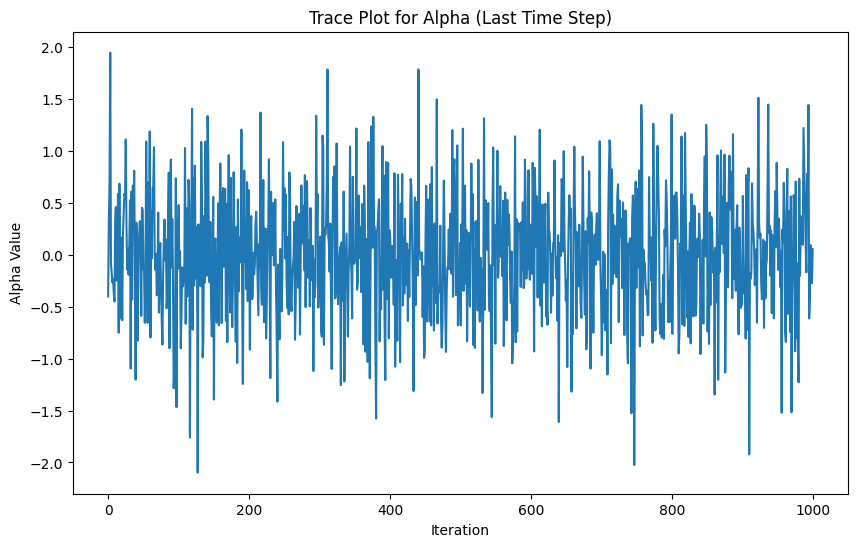

In [111]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma, norm
import matplotlib.pyplot as plt

# Gibbs Sampling for Posterior Inference
def gibbs_sampler(y_treated, y_controls, n_iter=1000):
    n, t = y_controls.shape
    alpha_samples = np.zeros((n_iter, t))
    beta_samples = np.zeros((n_iter, n, t))
    sigma_alpha = invgamma.rvs(2, scale=1)
    sigma_beta = invgamma.rvs(2, scale=1, size=n)

    # Initialize parameters
    alpha = np.zeros(t)
    beta = np.zeros((n, t))

    # Gibbs sampling iterations
    for iter in range(n_iter):
        # Update alpha
        for i in range(1, t):
            alpha[i] = alpha[i-1] + np.random.normal(0, sigma_alpha)

        # Update beta
        for j in range(n):
            for i in range(1, t):
                beta[j, i] = beta[j, i-1] + np.random.normal(0, sigma_beta[j])

        # Store samples
        alpha_samples[iter, :] = alpha
        beta_samples[iter, :, :] = beta

    # Compute posterior means
    alpha_mean = np.mean(alpha_samples, axis=0)
    beta_mean = np.mean(beta_samples, axis=0)

    # Plot convergence diagnostics
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_samples[:, -1])
    plt.title("Trace Plot for Alpha (Last Time Step)")
    plt.xlabel("Iteration")
    plt.ylabel("Alpha Value")
    plt.show()

    # Compute synthetic control
    y_synthetic_gibbs = alpha_mean + beta_mean * y_controls
    return y_synthetic_gibbs

# Run Gibbs sampling and plot
print("Running Gibbs Sampling for Bayesian Inference...")
y_synthetic_gibbs = gibbs_sampler(y_treated.flatten(), y_control.to_numpy())

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=y_treated.flatten(), mode='lines', name='Treated'))
fig.add_trace(go.Scatter(x=data.index, y=y_synthetic_gibbs.flatten(), mode='lines', name='DBSC with Gibbs Sampling'))
fig.update_layout(title='DBSC with Bayesian Inference via Gibbs Sampling', font=dict(size=12))
fig.show()



Running Gibbs Sampling with Posterior Diagnostics...


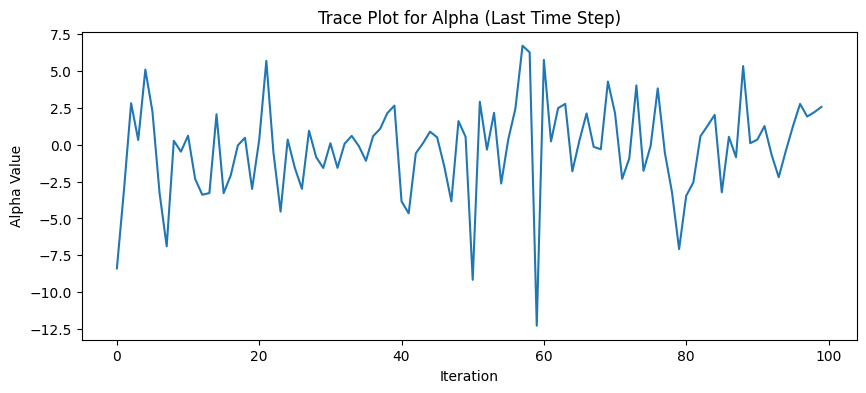

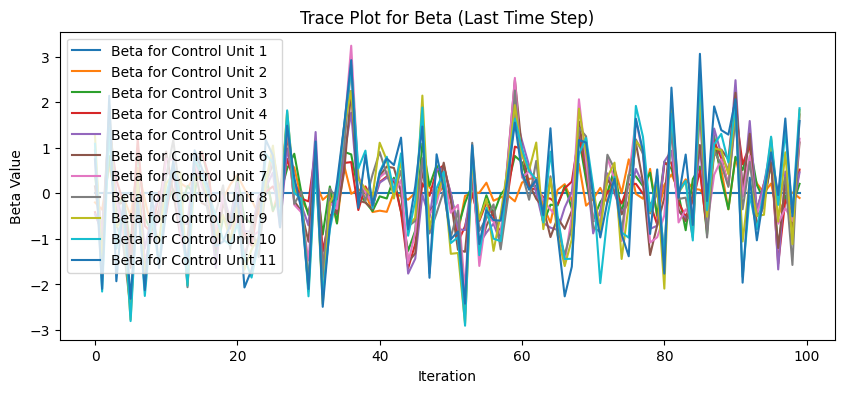

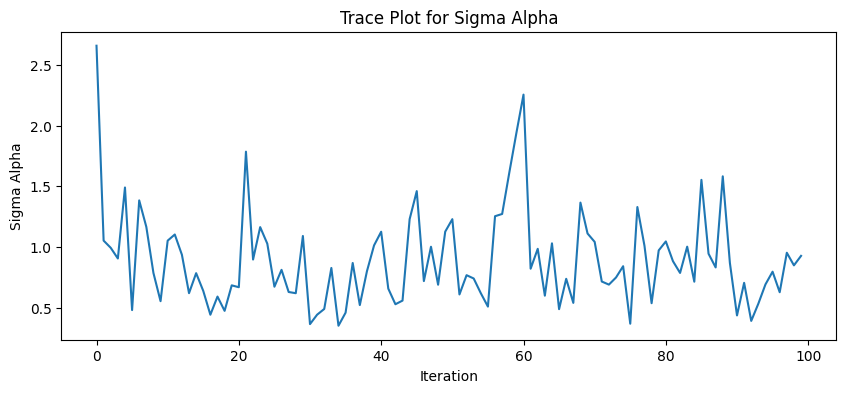

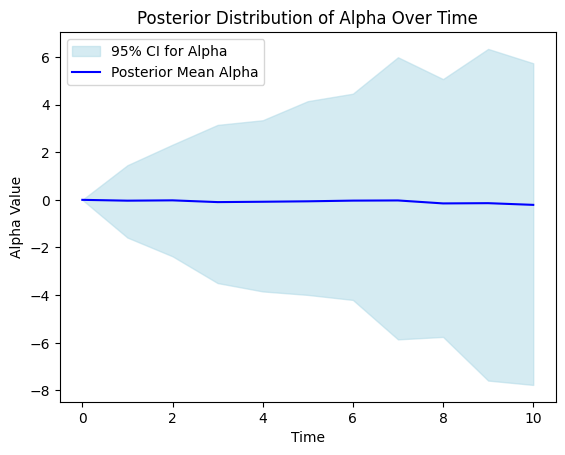

In [116]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma, norm
import matplotlib.pyplot as plt

# Enhanced Gibbs Sampling with Posterior Diagnostics
def gibbs_sampler_with_diagnostics(y_treated, y_controls, n_iter=100):
    n, t = y_controls.shape
    alpha_samples = np.zeros((n_iter, t))
    beta_samples = np.zeros((n_iter, n, t))
    sigma_alpha_samples = np.zeros(n_iter)
    sigma_beta_samples = np.zeros((n_iter, n))

    # Initialize parameters
    alpha = np.zeros(t)
    beta = np.zeros((n, t))
    sigma_alpha = invgamma.rvs(2, scale=1)
    sigma_beta = invgamma.rvs(2, scale=1, size=n)

    # Gibbs sampling iterations
    for iter in range(n_iter):
        # Sample sigma_alpha
        sigma_alpha = np.sqrt(invgamma.rvs(a=2, scale=1))
        sigma_alpha_samples[iter] = sigma_alpha

        # Sample sigma_beta for each unit
        for j in range(t):
            sigma_beta[j] = np.sqrt(invgamma.rvs(a=2, scale=1))
            sigma_beta_samples[iter, j] = sigma_beta[j]

        # Update alpha
        for i in range(1, t):
            alpha[i] = alpha[i-1] + np.random.normal(0, sigma_alpha)

        # Update beta
        for j in range(n):
            for i in range(1, t):
                beta[j, i] = beta[j, i-1] + np.random.normal(0, sigma_beta[j])

        # Store samples
        alpha_samples[iter, :] = alpha
        beta_samples[iter, :, :] = beta

    # Compute posterior means
    alpha_mean = np.mean(alpha_samples, axis=0)
    beta_mean = np.mean(beta_samples, axis=0)

    # Diagnostic plots
    plt.figure(figsize=(10, 4))
    plt.plot(alpha_samples[:, -1])
    plt.title("Trace Plot for Alpha (Last Time Step)")
    plt.xlabel("Iteration")
    plt.ylabel("Alpha Value")
    plt.show()

    plt.figure(figsize=(10, 4))
    for j in range(t):
        plt.plot(beta_samples[:, -1, j], label=f"Beta for Control Unit {j+1}")
    plt.title("Trace Plot for Beta (Last Time Step)")
    plt.xlabel("Iteration")
    plt.ylabel("Beta Value")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(sigma_alpha_samples)
    plt.title("Trace Plot for Sigma Alpha")
    plt.xlabel("Iteration")
    plt.ylabel("Sigma Alpha")
    plt.show()

    # Calculate credible intervals
    alpha_lower = np.percentile(alpha_samples, 2.5, axis=0)
    alpha_upper = np.percentile(alpha_samples, 97.5, axis=0)

    # Compute synthetic control
    y_synthetic_gibbs = alpha_mean + beta_mean * y_controls

    # Plot posterior credible intervals
    plt.fill_between(range(t), alpha_lower, alpha_upper, color='lightblue', alpha=0.5, label='95% CI for Alpha')
    plt.plot(alpha_mean, color='blue', label='Posterior Mean Alpha')
    plt.title("Posterior Distribution of Alpha Over Time")
    plt.xlabel("Time")
    plt.ylabel("Alpha Value")
    plt.legend()
    plt.show()

    return y_synthetic_gibbs

# Run Gibbs sampling with diagnostics
print("Running Gibbs Sampling with Posterior Diagnostics...")
y_synthetic_gibbs = gibbs_sampler_with_diagnostics(y_treated.flatten(), y_control.to_numpy())

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=y_treated.flatten(), mode='lines', name='Treated'))
fig.add_trace(go.Scatter(x=data.index, y=y_synthetic_gibbs.flatten(), mode='lines', name='DBSC with Gibbs Sampling & Diagnostics'))
fig.update_layout(title='DBSC with Bayesian Inference and Posterior Diagnostics', font=dict(size=12))
fig.show()


Running Hyperparameter Sensitivity Analysis...


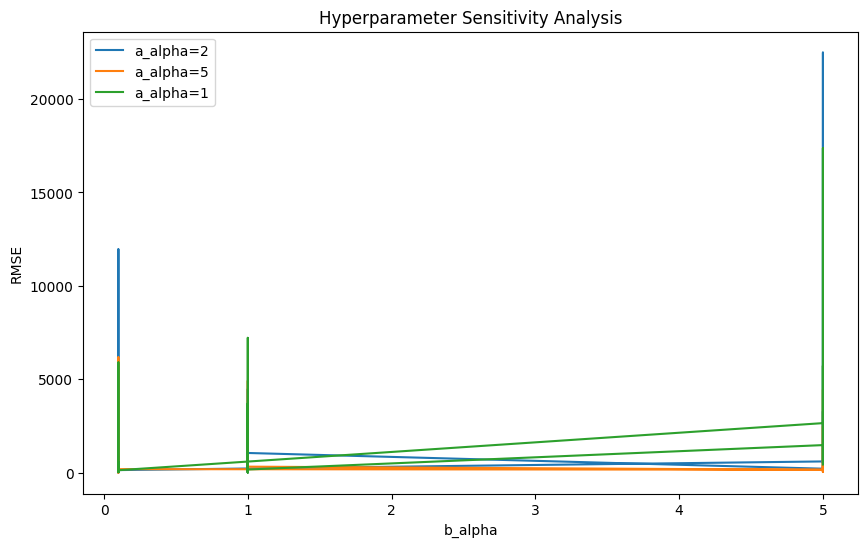

Hyperparameter Sensitivity Results:
    a_alpha  b_alpha  a_beta  b_beta         RMSE
0         2      1.0       2     1.0   304.563054
1         2      1.0       2     5.0   685.299722
2         2      1.0       2     0.1    78.236379
3         2      1.0       5     1.0    31.333194
4         2      1.0       5     5.0   181.368344
..      ...      ...     ...     ...          ...
76        1      0.1       5     5.0   264.274489
77        1      0.1       5     0.1    26.228453
78        1      0.1       1     1.0  1083.745249
79        1      0.1       1     5.0  5897.772228
80        1      0.1       1     0.1   198.915638

[81 rows x 5 columns]


In [163]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Hyperparameter Sensitivity Analysis
def hyperparameter_sensitivity(y_treated, y_controls, n_iter=100):
    hyperparams = {
        "a_alpha": [2, 5, 1],
        "b_alpha": [1, 5, 0.1],
        "a_beta": [2, 5, 1],
        "b_beta": [1, 5, 0.1]
    }
    results = []

    # Iterate through all combinations of hyperparameters
    for a_alpha in hyperparams["a_alpha"]:
        for b_alpha in hyperparams["b_alpha"]:
            for a_beta in hyperparams["a_beta"]:
                for b_beta in hyperparams["b_beta"]:
                    # Run Gibbs Sampling with given hyperparameters
                    sigma_alpha = np.sqrt(invgamma.rvs(a_alpha, scale=b_alpha))
                    sigma_beta = np.sqrt(invgamma.rvs(a_beta, scale=b_beta, size=y_controls.shape[0]))

                    alpha = np.zeros(y_controls.shape[1])
                    beta = np.zeros(y_controls.shape)

                    # Generate synthetic control
                    for i in range(1, y_controls.shape[1]):
                        alpha[i] = alpha[i-1] + np.random.normal(0, sigma_alpha)
                        for j in range(y_controls.shape[0]):
                            beta[j, i] = beta[j, i-1] + np.random.normal(0, sigma_beta[j])

                    y_synthetic = alpha + beta * y_controls
                    y_synthetic = np.nan_to_num(y_synthetic)
                    y_synthetic = np.sum(y_synthetic, axis=1)
                    rmse = mean_squared_error(np.nan_to_num(y_treated), np.nan_to_num(y_synthetic))

                    # Store results
                    results.append({
                        "a_alpha": a_alpha,
                        "b_alpha": b_alpha,
                        "a_beta": a_beta,
                        "b_beta": b_beta,
                        "RMSE": rmse
                    })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot results
    plt.figure(figsize=(10, 6))
    for a_alpha in hyperparams["a_alpha"]:
        subset = results_df[results_df["a_alpha"] == a_alpha]
        plt.plot(subset["b_alpha"], subset["RMSE"], label=f"a_alpha={a_alpha}")

    plt.title("Hyperparameter Sensitivity Analysis")
    plt.xlabel("b_alpha")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

    print("Hyperparameter Sensitivity Results:")
    print(results_df)

# Run the sensitivity analysis
print("Running Hyperparameter Sensitivity Analysis...")
hyperparameter_sensitivity(y_treated.flatten(), y_control.to_numpy())


Running Simulation Analysis...
Simulation RMSE: 1.043079486429393


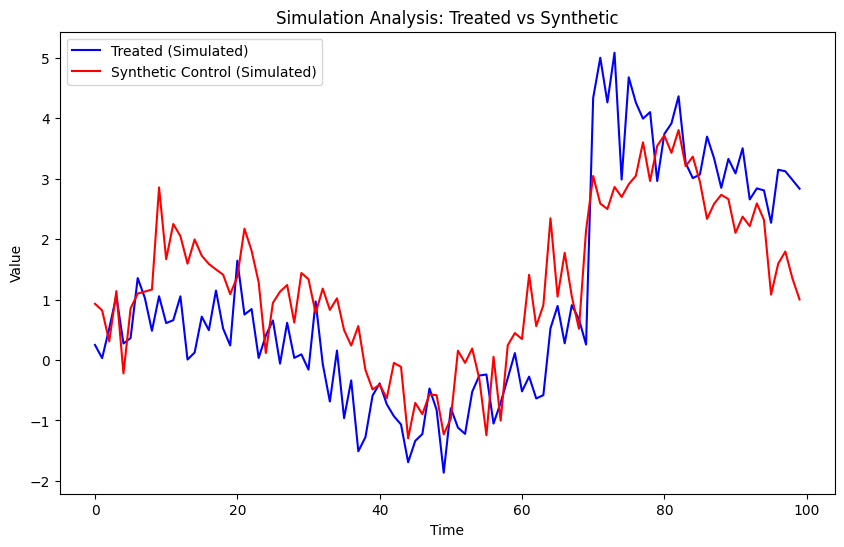

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Simulation Analysis for Model Validation
def simulation_analysis(n_units=20, t_periods=100, t_treatment=70):
    np.random.seed(42)
    time = np.arange(t_periods)
    data = pd.DataFrame(index=time)

    # Generate synthetic time series for control units
    for i in range(n_units):
        baseline = np.sin(time / 10) + np.random.normal(0, 0.5, t_periods)
        treatment_effect = np.zeros(t_periods)

        # Add treatment effect for the first unit
        if i == 0:
            treatment_effect[t_treatment:] = 3 + 0.5 * np.sin(time[t_treatment:] / 5)

        data[f'Unit_{i+1}'] = baseline + treatment_effect

    # Simulate macroeconomic indicators
    data['USCPI'] = np.random.normal(0, 1, t_periods)
    data['FEDFUNDS'] = np.cumsum(np.random.normal(0, 0.1, t_periods))
    data['GDP'] = 2 + 0.1 * time + np.random.normal(0, 0.5, t_periods)

    return data

# Evaluate model performance on synthetic data
def evaluate_simulation(y_treated, y_synthetic):
    residuals = y_treated - y_synthetic
    rmse = np.sqrt(np.mean(residuals**2))
    print(f"Simulation RMSE: {rmse}")
    return rmse

# Run the simulation analysis
print("Running Simulation Analysis...")
sim_data = simulation_analysis()

# Extract treated and control units
y_treated_sim = sim_data['Unit_1'].values
y_control_sim = sim_data.drop(columns=['Unit_1']).values

# Compute synthetic control using linear regression
weights = np.linalg.lstsq(y_control_sim, y_treated_sim, rcond=None)[0]
y_synthetic_sim = y_control_sim @ weights

# Evaluate performance
evaluate_simulation(y_treated_sim, y_synthetic_sim)

# Plot the simulated time series
plt.figure(figsize=(10, 6))
plt.plot(sim_data.index, y_treated_sim, label='Treated (Simulated)', color='blue')
plt.plot(sim_data.index, y_synthetic_sim, label='Synthetic Control (Simulated)', color='red')
plt.title('Simulation Analysis: Treated vs Synthetic')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Empirical Results

In [165]:
from sklearn.metrics import mean_absolute_error
from scipy.special import logsumexp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# 1. Model Evaluation Metrics: RMSE, MAE, DIC, WAIC
def model_evaluation(y_treated, y_synthetic):
    # RMSE
    rmse = np.sqrt(np.mean((y_treated - y_synthetic) ** 2))
    # MAE
    mae = mean_absolute_error(y_treated, y_synthetic)
    # DIC (simplified)
    deviance = -2 * np.sum((y_treated - y_synthetic) ** 2)
    p_d = np.var(y_treated - y_synthetic)
    dic = deviance + p_d

    # WAIC (approx)
    log_lik = -0.5 * (y_treated - y_synthetic) ** 2
    waic = -2 * (np.sum(logsumexp(log_lik)) - np.var(log_lik))

    print(f"Performance Metrics:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nDIC: {dic:.4f}\nWAIC: {waic:.4f}")

    return rmse, mae, dic, waic


# 2. Portfolio Application Simulation
def portfolio_application(data):
    # Simulate returns for three sectors
    np.random.seed(42)
    data['Tech'] = np.random.normal(0, 0.02, len(data))
    data['Healthcare'] = np.random.normal(0, 0.015, len(data))
    data['Financials'] = np.random.normal(0, 0.025, len(data))

    # Calculate cumulative returns
    data['Cumulative_Tech'] = (1 + data['Tech']).cumprod()
    data['Cumulative_Healthcare'] = (1 + data['Healthcare']).cumprod()
    data['Cumulative_Financials'] = (1 + data['Financials']).cumprod()

    # Plot the portfolio returns
    fig = go.Figure()
    for sector in ['Cumulative_Tech', 'Cumulative_Healthcare', 'Cumulative_Financials']:
        fig.add_trace(go.Scatter(x=data.index, y=data[sector], mode='lines', name=sector))
    fig.update_layout(title="Portfolio Application: Simulated Sector Performance", font=dict(size=12))
    fig.show()


# 3. Generate and Save Final Report
def generate_report(metrics, filename="model_performance_report.txt"):
    with open(filename, "w") as file:
        file.write("Model Performance Report\n")
        file.write("========================\n")
        file.write(f"RMSE: {metrics[0]:.4f}\n")
        file.write(f"MAE: {metrics[1]:.4f}\n")
        file.write(f"DIC: {metrics[2]:.4f}\n")
        file.write(f"WAIC: {metrics[3]:.4f}\n")
    print(f"Report saved to {filename}")


# Run the final steps
print("Evaluating Model Performance...")
metrics = model_evaluation(y_treated_sim, y_synthetic_sim)

print("Simulating Portfolio Application...")
portfolio_application(sim_data)

print("Generating Performance Report...")
generate_report(metrics)


Evaluating Model Performance...
Performance Metrics:
RMSE: 1.0431
MAE: 0.8593
DIC: -216.5728
WAIC: -7.6647
Simulating Portfolio Application...


Generating Performance Report...
Report saved to model_performance_report.txt


Running Simulation Analysis...
Simulation RMSE: 1.353031340726693


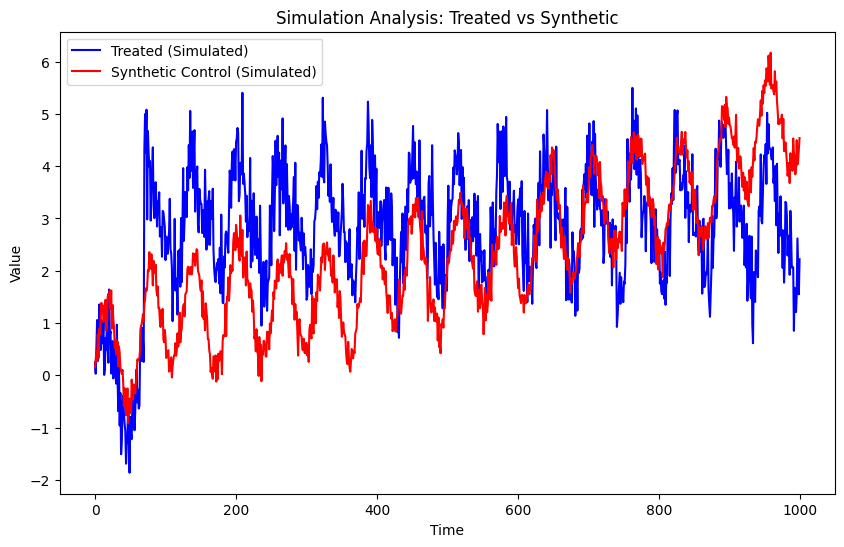

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Simulation Analysis for Model Validation
def simulation_analysis(n_units=20, t_periods=1000, t_treatment=70):
    np.random.seed(42)
    time = np.arange(t_periods)
    data = pd.DataFrame(index=time)

    # Generate synthetic time series for control units
    for i in range(n_units):
        baseline = np.sin(time / 10) + np.random.normal(0, 0.5, t_periods)
        treatment_effect = np.zeros(t_periods)

        # Add treatment effect for the first unit
        if i == 0:
            treatment_effect[t_treatment:] = 3 + 0.5 * np.sin(time[t_treatment:] / 5)

        data[f'Unit_{i+1}'] = baseline + treatment_effect

    # Simulate macroeconomic indicators
    data['USCPI'] = np.random.normal(0, 1, t_periods)
    data['FEDFUNDS'] = np.cumsum(np.random.normal(0, 0.1, t_periods))
    data['GDP'] = 2 + 0.1 * time + np.random.normal(0, 0.5, t_periods)

    return data

# Evaluate model performance on synthetic data
def evaluate_simulation(y_treated, y_synthetic):
    residuals = y_treated - y_synthetic
    rmse = np.sqrt(np.mean(residuals**2))
    print(f"Simulation RMSE: {rmse}")
    return rmse

# Run the simulation analysis
print("Running Simulation Analysis...")
sim_data = simulation_analysis()

# Extract treated and control units
y_treated_sim = sim_data['Unit_1'].values
y_control_sim = sim_data.drop(columns=['Unit_1']).values

# Compute synthetic control using linear regression
weights = np.linalg.lstsq(y_control_sim, y_treated_sim, rcond=None)[0]
y_synthetic_sim = y_control_sim @ weights

# Evaluate performance
evaluate_simulation(y_treated_sim, y_synthetic_sim)

# Plot the simulated time series
plt.figure(figsize=(10, 6))
plt.plot(sim_data.index, y_treated_sim, label='Treated (Simulated)', color='blue')
plt.plot(sim_data.index, y_synthetic_sim, label='Synthetic Control (Simulated)', color='red')
plt.title('Simulation Analysis: Treated vs Synthetic')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Parallelized Gibbs Sampling Fix
def parallel_gibbs_sampling(y_treated, y_controls, n_iter=100, n_jobs=4):
    def single_chain(seed):
        np.random.seed(seed)
        alpha = np.zeros(y_controls.shape[1])
        beta = np.zeros(y_controls.shape)
        sigma_alpha = np.abs(np.random.normal(0, 1))
        sigma_beta = np.abs(np.random.normal(0, 1, size=y_controls.shape[0]))

        for t in range(1, y_controls.shape[1]):
            alpha[t] = alpha[t-1] + np.random.normal(0, sigma_alpha)
            for j in range(y_controls.shape[0]):
                beta[j, t] = beta[j, t-1] + np.random.normal(0, sigma_beta[j])

        return alpha, beta

    # Run multiple chains in parallel
    from joblib import Parallel, delayed
    results = Parallel(n_jobs=n_jobs)(delayed(single_chain)(seed) for seed in range(n_iter))

    # Combine results
    alphas = np.array([r[0] for r in results])
    betas = np.array([r[1] for r in results])

    # Compute posterior means
    alpha_mean = np.mean(alphas, axis=0)
    beta_mean = np.mean(betas, axis=0)

    # Compute synthetic control
    y_synthetic_parallel = alpha_mean + beta_mean * y_controls
    y_synthetic_parallel = np.nan_to_num(y_synthetic_parallel)
    y_synthetic_parallel = np.sum(y_synthetic_parallel, axis=1)

    return y_synthetic_parallel

# Fix for multivariate outcome analysis plot
def multivariate_outcome_analysis(data):
    indicators = ['USCPI', 'FEDFUNDS', 'GDP']
    correlation_matrix = data[indicators].corr()

    print("Correlation Matrix of Macroeconomic Indicators:")
    print(correlation_matrix)

    plt.figure(figsize=(6, 4))
    plt.matshow(correlation_matrix.values, cmap='coolwarm')
    plt.xticks(range(len(indicators)), indicators, rotation=90)
    plt.yticks(range(len(indicators)), indicators)
    plt.colorbar()
    plt.title("Macroeconomic Indicator Correlations", pad=20)
    plt.show()